In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

https://r2rt.com/recurrent-neural-networks-in-tensorflow-iii-variable-length-sequences.html

In [2]:
from __future__ import division
import tensorflow as tf
from os import path
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from mylibs.jupyter_notebook_helper import show_graph
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner
from IPython.display import Image
from IPython.core.display import HTML
from mylibs.tf_helper import getDefaultGPUconfig
from sklearn.metrics import r2_score
from mylibs.py_helper import factors
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from data_providers.price_history_full_len_data_provider \
    import PriceHistoryFullLenDataProvider
from models.price_history_rnn_full_len import PriceHistoryRnnFullLen

/home/student/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
dtype = tf.float32
seed = 16011984
random_state = np.random.RandomState(seed=seed)
config = getDefaultGPUconfig()
%matplotlib inline

In [4]:
from common import get_or_run_nn

### Step 0 - hyperparams

In [5]:
num_epochs = 10
input_len = 60
num_features = 1
state_size = 400
target_len = 30
batch_size = 47

### Step 1 - collect data (and/or generate them)

In [6]:
csv_in = '../price_history_03a_fixed_width.csv'
npz_path = '../price_history_03_dp_60to30_from_fixed_len.npz'

In [7]:
# XX, YY, sequence_lens, seq_mask = PriceHistoryGenerator.createAndSaveDataset(
#     csv_in=csv_in,
#     npz_out=npz_path,
#     input_seq_len=60, target_seq_len=30)
# XX.shape, YY.shape, sequence_lens.shape, seq_mask.shape

In [8]:
dp = PriceHistoryFullLenDataProvider(npz_path=npz_path, batch_size=batch_size)
dp.inputs.shape, dp.targets.shape

((11374, 60, 1), (11374, 30))

### Step 2 - Build model

In [9]:
model = PriceHistoryRnnFullLen(rng=random_state, dtype=dtype, config=config)

In [10]:
graph = model.getGraph(batch_size=batch_size,
                       state_size=state_size,
                       input_len=input_len,
                       target_len=target_len)

learning rate: 0.001000
60
Tensor("inputs/unstack:0", shape=(47, 1), dtype=float32)

60
Tensor("rnn_layer/rnn/basic_rnn_cell/Tanh:0", shape=(47, 400), dtype=float32)

30
Tensor("readout_layer/add:0", shape=(47, 1), dtype=float32)

Tensor("predictions/Reshape:0", shape=(47, 30), dtype=float32)

Tensor("error/Select:0", shape=(47, 30), dtype=float32)

Tensor("error/Mean:0", shape=(), dtype=float32)



In [11]:
show_graph(graph)

### Step 3 training the network

## GRU cell - with full len rnn

In [16]:
rnn_cell = PriceHistoryRnnFullLen.RNN_CELLS.GRU
num_epochs, state_size, batch_size

(10, 400, 47)

In [17]:
def experiment():
    return model.run(epochs=num_epochs,
                        rnn_cell=rnn_cell,
                        state_size=state_size,
                        input_len=input_len,
                        target_len=target_len,
                        npz_path=npz_path,
                        batch_size=batch_size)

In [18]:
dyn_stats = experiment()

epochs: 10
End Epoch 01 (34.071 secs): err(train) = 7.7790
End Epoch 02 (33.643 secs): err(train) = 6.9922
End Epoch 03 (33.722 secs): err(train) = 6.4895
End Epoch 04 (33.584 secs): err(train) = 5.9770
End Epoch 05 (33.622 secs): err(train) = 5.5152
End Epoch 06 (33.686 secs): err(train) = 5.0365
End Epoch 07 (33.704 secs): err(train) = 4.6243
End Epoch 08 (34.428 secs): err(train) = 4.1684
End Epoch 09 (33.952 secs): err(train) = 3.8530
End Epoch 10 (33.800 secs): err(train) = 3.5236



In [21]:
# dyn_stats, preds_dict = get_or_run_nn(experiment,
#                                       filename='002_rnn_gru_60to30')
# epochs: 10
# End Epoch 01 (43.118 secs): err(train) = 7.8218
# End Epoch 02 (41.229 secs): err(train) = 6.9381
# End Epoch 03 (41.370 secs): err(train) = 6.4451
# End Epoch 04 (41.662 secs): err(train) = 6.0338
# End Epoch 05 (41.484 secs): err(train) = 5.4984
# End Epoch 06 (41.337 secs): err(train) = 5.0515
# End Epoch 07 (41.292 secs): err(train) = 4.6289
# End Epoch 08 (43.233 secs): err(train) = 4.2015
# End Epoch 09 (43.128 secs): err(train) = 3.7842
# End Epoch 10 (41.224 secs): err(train) = 3.4302

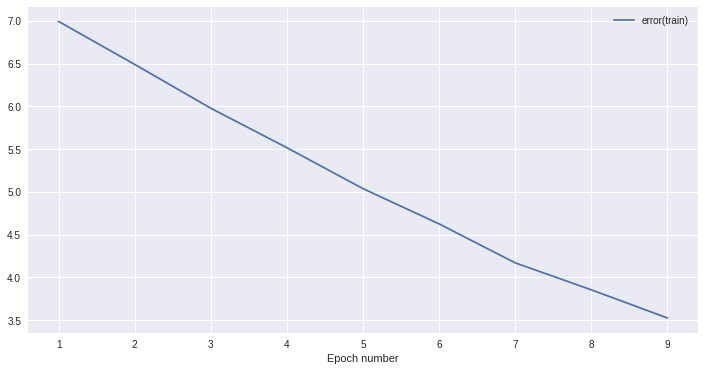

In [19]:
dyn_stats.plotStats()
plt.show()

#### Conclusion from run above
We notice that the static RNN has the same performance with the dynamic RNN in terms of training error but it trains faster because it skips all these parts that make it dynamic. The input sequence length is always 60. So we are going to prefer it because it trains faster

In [22]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

NameError: name 'preds_dict' is not defined

In [23]:
ind = np.argmin(r2_scores)
ind

NameError: name 'r2_scores' is not defined

In [19]:
reals = dp.targets[ind]
preds = preds_dict[ind]

In [20]:
r2_score(y_true=reals, y_pred=preds)

-1.7898149900928367e+31

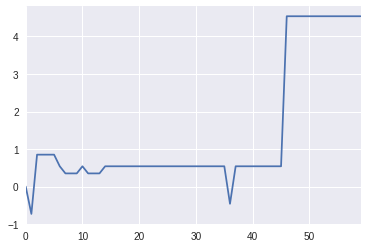

In [21]:
sns.tsplot(data=dp.inputs[ind].flatten())

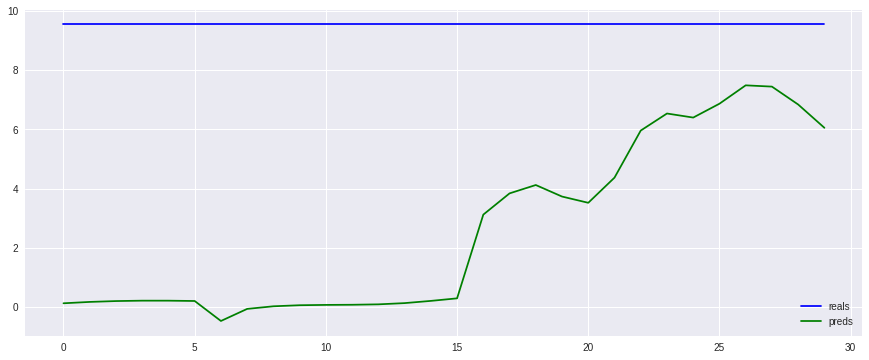

In [22]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [23]:
%%time
dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
             for ind in range(len(dp.targets))]

CPU times: user 25.6 s, sys: 112 ms, total: 25.7 s
Wall time: 25.6 s


In [24]:
np.mean(dtw_scores)

97.121502617895061

In [25]:
coint(preds, reals)

(-2.306996326148862,
 0.3700669207661037,
 array([-4.31395736, -3.55493606, -3.19393252]))

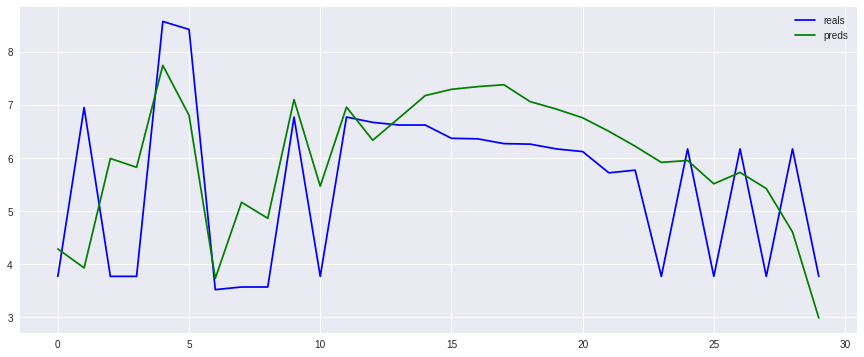

In [34]:
cur_ind = np.random.randint(len(dp.targets))
reals = dp.targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()